# Training Baseline Empathy Classifier

This notebook trains and evaluates the baseline empathy type classifier.

**For Google Colab**: Upload the entire `empathy-classifier` folder to your Google Drive, then run all cells.


In [3]:
# Setup for Google Colab
try:
    import google.colab
    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)

    # Navigate to project folder
    import os
    project_path = '/content/drive/MyDrive/LLMES/empathy-classifier'
    os.chdir(project_path)

    # Install dependencies
    import subprocess
    subprocess.run(['pip', 'install', '-q', 'torch', 'transformers', 'pandas', 'numpy', 'scikit-learn', 'seaborn', 'matplotlib'],
                   check=False)

    print("Colab setup complete!")
    print(f"Current directory: {os.getcwd()}")

    # Add src to path (we're already in empathy-classifier, so src is directly here)
    import sys
    sys.path.insert(0, os.path.join(project_path, 'src'))

except ImportError:
    print("Running locally")
    import os
    import sys
    # For local, we're in notebooks folder, so go up one level
    sys.path.append(os.path.join('..', 'src'))

# Import training function
from train import train_model

print("Ready to train!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Colab setup complete!
Current directory: /content/drive/MyDrive/LLMES/empathy-classifier
Ready to train!


In [6]:
# Sanity check: Verify gradients are flowing
from model import BaselineModel
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from data import get_dataloaders

def soft_cross_entropy(pred, target):
    return -torch.sum(target * torch.log(pred + 1e-8), dim=1).mean()

# Get one batch
train_loader, _, _ = get_dataloaders(batch_size=32)

model = BaselineModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Get one batch
batch = next(iter(train_loader))
input_ids = batch['input_ids'].to(device)
attention_mask = batch['attention_mask'].to(device)
labels = batch['labels'].to(device)

# Forward and backward
probs = model(input_ids, attention_mask)
loss = soft_cross_entropy(probs, labels)
loss.backward()

# Check if classifier has gradients
print("Classifier weight grad:", model.classifier.weight.grad is not None)
if model.classifier.weight.grad is not None:
    print("Classifier grad norm:", model.classifier.weight.grad.norm().item())
    print("Classifier grad sample:", model.classifier.weight.grad[0, :5])

# Check BERT (should be None since frozen)
print("BERT param grad:", any(p.grad is not None for p in model.bert.parameters()))

Classifier weight grad: True
Classifier grad norm: 2.087156057357788
Classifier grad sample: tensor([-0.0043,  0.0042,  0.0163,  0.0156, -0.0084], device='cuda:0')
BERT param grad: False


## Option 1: Train with Default Hyperparameters


In [8]:
# Train with default hyperparameters (with custom learning rate)
model_path = os.path.join('..', 'models', 'baseline_v1.pt')
os.makedirs(os.path.dirname(model_path), exist_ok=True)

best_eval_loss = train_model(
    model_save_path=model_path,
    learning_rate=0.003  # Change this value
)
print(f"\nBest evaluation loss: {best_eval_loss:.4f}")

Starting training...
Max epochs: 50, Early stopping patience: 5, Batch size: 32, Learning rate: 0.003
Epoch 1/50 - Train Loss: 1.1081, Eval Loss: 1.0998
Epoch 2/50 - Train Loss: 1.0995, Eval Loss: 1.0997
Epoch 3/50 - Train Loss: 1.0981, Eval Loss: 1.1008
Epoch 4/50 - Train Loss: 1.0987, Eval Loss: 1.0986
Epoch 5/50 - Train Loss: 1.0989, Eval Loss: 1.1038
Epoch 6/50 - Train Loss: 1.0987, Eval Loss: 1.1057
Epoch 7/50 - Train Loss: 1.0996, Eval Loss: 1.0990
Epoch 8/50 - Train Loss: 1.0978, Eval Loss: 1.1032
Epoch 9/50 - Train Loss: 1.0986, Eval Loss: 1.1042
Early stopping at epoch 9
Training completed.

Best evaluation loss: 1.0986


## Qualitative Analysis: Sample Predictions

This cell visualizes predictions on a few test samples to qualitatively assess model performance. For each sample, we show:

- **True labels**: The actual empathy type distribution from human raters
- **Model predictions**: The trained model's predicted probability distribution
- **Random baseline**: Predictions from a random baseline that samples from the training data distribution (mean and variance)

The visualization helps us understand:
- How well the model aligns with true labels
- Whether the model captures the soft label structure (not just hard classification)
- How much better the trained model performs compared to random guessing

Each bar chart shows three bars per empathy type (Cognitive, Affective, Motivational):
- **Solid bars (lighter)**: True labels
- **Hatched bars (darker)**: Model predictions  
- **Dotted bars (lightest)**: Random baseline

Training label statistics:
  Mean: Cognitive=0.353, Affective=0.315, Motivational=0.333
  Std:  Cognitive=0.042, Affective=0.040, Motivational=0.040


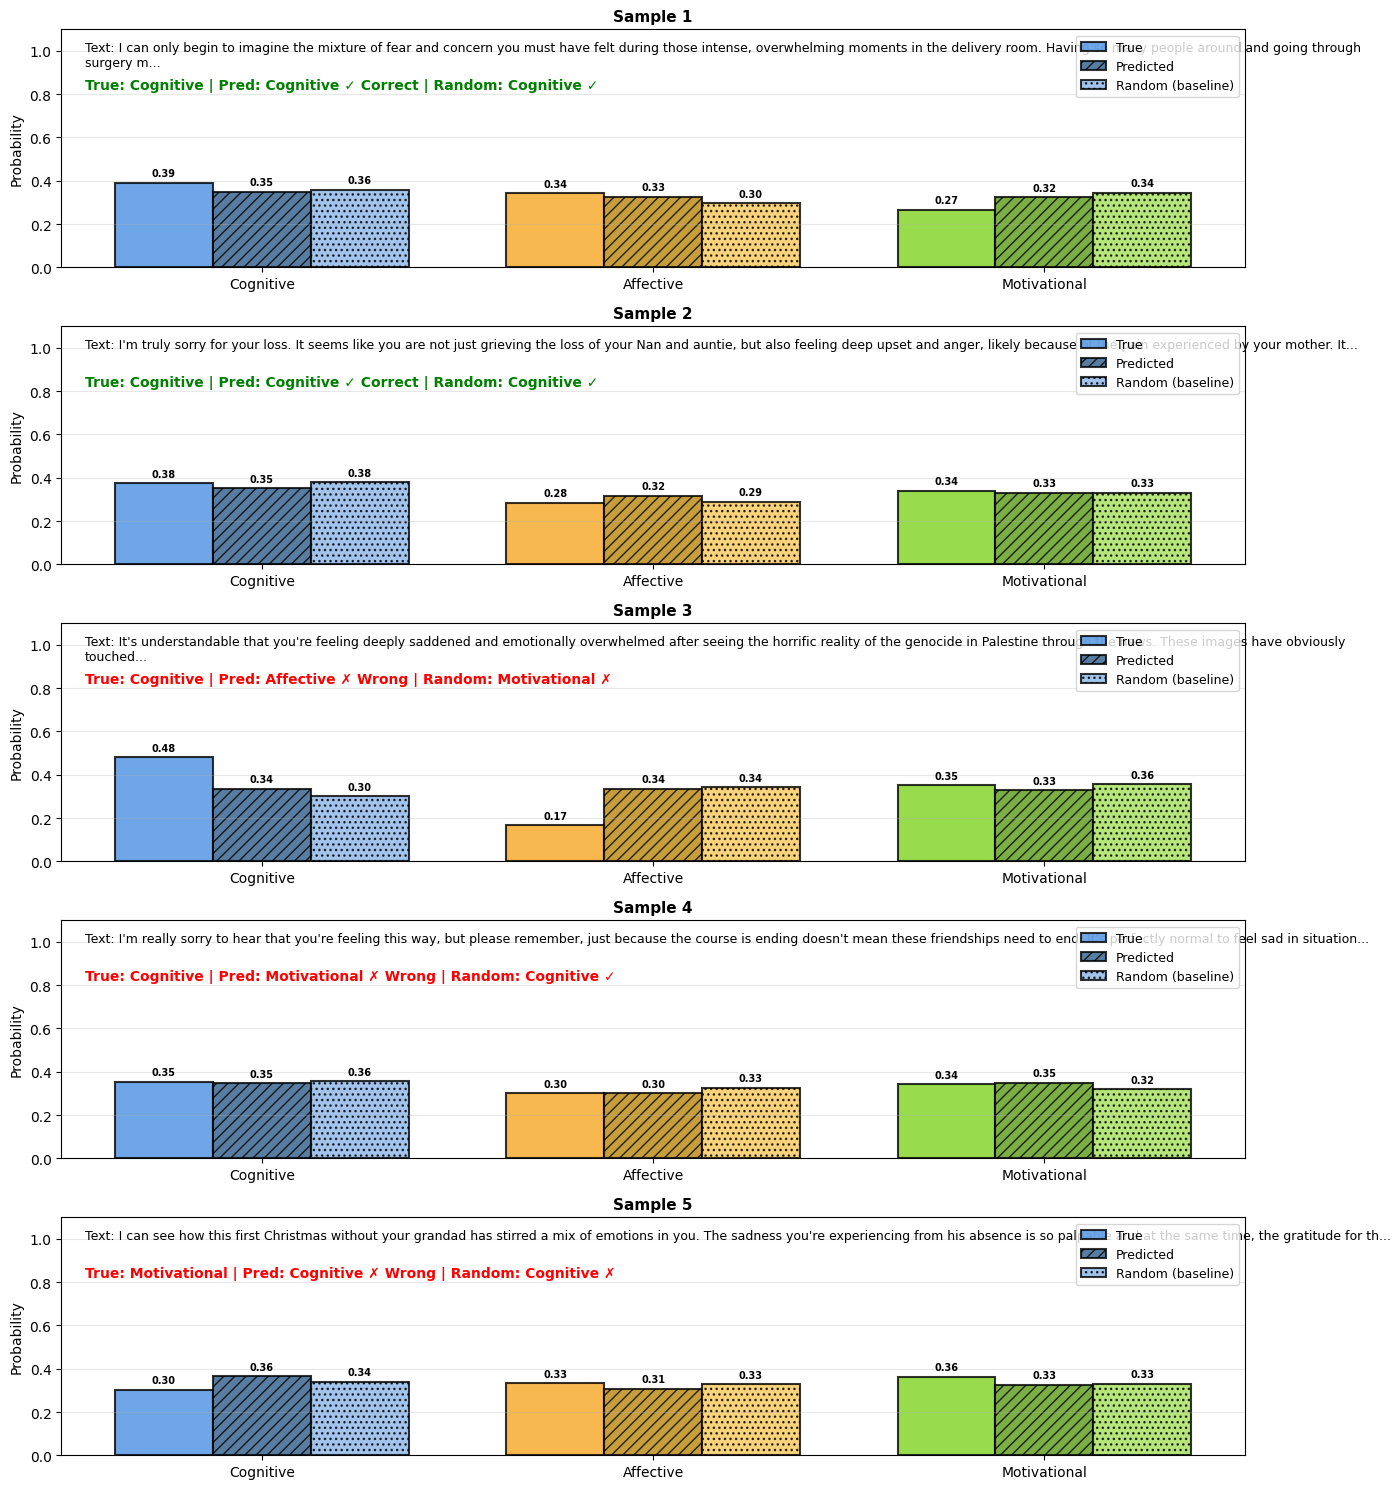


PREDICTION SUMMARY

Sample 1:
  True: Cognitive    | Pred: Cognitive    | Random: Cognitive   
  Correct: Pred=✓, Random=✓
  True probs:  Cog=0.391, Aff=0.344, Mot=0.266
  Pred probs:  Cog=0.350, Aff=0.326, Mot=0.325
  Random:     Cog=0.358, Aff=0.297, Mot=0.345

Sample 2:
  True: Cognitive    | Pred: Cognitive    | Random: Cognitive   
  Correct: Pred=✓, Random=✓
  True probs:  Cog=0.375, Aff=0.284, Mot=0.341
  Pred probs:  Cog=0.352, Aff=0.316, Mot=0.332
  Random:     Cog=0.379, Aff=0.290, Mot=0.331

Sample 3:
  True: Cognitive    | Pred: Affective    | Random: Motivational
  Correct: Pred=✗, Random=✗
  True probs:  Cog=0.481, Aff=0.167, Mot=0.352
  Pred probs:  Cog=0.336, Aff=0.336, Mot=0.328
  Random:     Cog=0.300, Aff=0.343, Mot=0.358

Sample 4:
  True: Cognitive    | Pred: Motivational | Random: Cognitive   
  Correct: Pred=✗, Random=✓
  True probs:  Cog=0.355, Aff=0.301, Mot=0.344
  Pred probs:  Cog=0.348, Aff=0.302, Mot=0.350
  Random:     Cog=0.355, Aff=0.327, Mot=0.318

Sam

In [12]:
# Visualize predictions on test samples (with random baseline)
from model import BaselineModel
from data import get_dataloaders
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load trained model
model = BaselineModel().to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

# Get training data to compute baseline statistics
train_loader, _, test_loader = get_dataloaders(batch_size=32)

# Compute mean and std of training labels for baseline
all_train_labels = []
for batch in train_loader:
    all_train_labels.append(batch['labels'].numpy())
all_train_labels = np.vstack(all_train_labels)
train_mean = all_train_labels.mean(axis=0)
train_std = all_train_labels.std(axis=0)

print(f"Training label statistics:")
print(f"  Mean: Cognitive={train_mean[0]:.3f}, Affective={train_mean[1]:.3f}, Motivational={train_mean[2]:.3f}")
print(f"  Std:  Cognitive={train_std[0]:.3f}, Affective={train_std[1]:.3f}, Motivational={train_std[2]:.3f}")

# Load original data for texts
data_path = os.path.join('data', 'raw', 'Supplementary Data - Responses and Measures - all experiments (1).csv')
if not os.path.exists(data_path):
    data_path = os.path.join('..', 'data', 'raw', 'Supplementary Data - Responses and Measures - all experiments (1).csv')

df = pd.read_csv(data_path)
df = df[df['StudyNum'] == '3'].copy()
texts = df['Response'].fillna('').astype(str).tolist()

# Get a few samples
num_samples = 5
samples = []
sample_count = 0

for i, batch in enumerate(test_loader):
    if sample_count >= num_samples:
        break

    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    with torch.no_grad():
        probs = model(input_ids, attention_mask)
        pred_hard = torch.argmax(probs, dim=1).cpu().numpy()
        true_hard = torch.argmax(labels, dim=1).cpu().numpy()
        true_soft = labels.cpu().numpy()
        pred_soft = probs.cpu().numpy()

    for j in range(len(pred_hard)):
        if sample_count >= num_samples:
            break

        idx = i * 32 + j
        if idx < len(texts):
            # Generate random baseline prediction based on training distribution
            # Sample from normal distribution and normalize to sum to 1
            np.random.seed(42 + sample_count)  # For reproducibility
            random_probs = np.random.normal(train_mean, train_std)
            random_probs = np.clip(random_probs, 0, 1)  # Clip to valid range
            random_probs = random_probs / random_probs.sum()  # Normalize to sum to 1
            random_hard = np.argmax(random_probs)

            samples.append({
                'text': texts[idx][:200] + '...' if len(texts[idx]) > 200 else texts[idx],
                'true_class': ['Cognitive', 'Affective', 'Motivational'][true_hard[j]],
                'pred_class': ['Cognitive', 'Affective', 'Motivational'][pred_hard[j]],
                'random_class': ['Cognitive', 'Affective', 'Motivational'][random_hard],
                'true_probs': true_soft[j],
                'pred_probs': pred_soft[j],
                'random_probs': random_probs,
                'correct': true_hard[j] == pred_hard[j],
                'random_correct': true_hard[j] == random_hard
            })
            sample_count += 1

# Create visualization
fig, axes = plt.subplots(num_samples, 1, figsize=(14, 3*num_samples))
if num_samples == 1:
    axes = [axes]

class_names = ['Cognitive', 'Affective', 'Motivational']

for idx, sample in enumerate(samples):
    ax = axes[idx]

    # Text and prediction info
    ax.text(0.02, 0.95, f"Text: {sample['text']}", transform=ax.transAxes,
            fontsize=9, verticalalignment='top', wrap=True)
    status = '✓ Correct' if sample['correct'] else '✗ Wrong'
    color_status = 'green' if sample['correct'] else 'red'
    random_status = '✓' if sample['random_correct'] else '✗'
    ax.text(0.02, 0.75, f"True: {sample['true_class']} | Pred: {sample['pred_class']} {status} | Random: {sample['random_class']} {random_status}",
            transform=ax.transAxes, fontsize=10, fontweight='bold', color=color_status)

    # Probability bars - three bars: True, Predicted, Random
    x_pos = np.arange(3)
    width = 0.25

    # True bars: solid, lighter colors
    true_bars = ax.bar(x_pos - width, sample['true_probs'], width,
                       label='True', alpha=0.8, color=['#4A90E2', '#F5A623', '#7ED321'],
                       edgecolor='black', linewidth=1.5)

    # Predicted bars: hatched pattern
    pred_bars = ax.bar(x_pos, sample['pred_probs'], width,
                       label='Predicted', alpha=0.8, color=['#2E5C8A', '#B8860B', '#5A9A15'],
                       edgecolor='black', linewidth=1.5, hatch='///')

    # Random bars: dotted pattern
    random_bars = ax.bar(x_pos + width, sample['random_probs'], width,
                         label='Random (baseline)', alpha=0.8, color=['#8BB4E8', '#F8C85A', '#A4E05A'],
                         edgecolor='black', linewidth=1.5, hatch='...')

    # Add value labels on bars
    for i, (true_val, pred_val, rand_val) in enumerate(zip(sample['true_probs'], sample['pred_probs'], sample['random_probs'])):
        ax.text(i - width, true_val + 0.02, f'{true_val:.2f}',
                ha='center', va='bottom', fontsize=7, fontweight='bold')
        ax.text(i, pred_val + 0.02, f'{pred_val:.2f}',
                ha='center', va='bottom', fontsize=7, fontweight='bold')
        ax.text(i + width, rand_val + 0.02, f'{rand_val:.2f}',
                ha='center', va='bottom', fontsize=7, fontweight='bold')

    ax.set_ylabel('Probability', fontsize=10)
    ax.set_title(f'Sample {idx+1}', fontsize=11, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(class_names, fontsize=10)
    ax.set_ylim([0, 1.1])
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print summary table
print("\n" + "="*80)
print("PREDICTION SUMMARY")
print("="*80)
for i, sample in enumerate(samples):
    print(f"\nSample {i+1}:")
    print(f"  True: {sample['true_class']:12} | Pred: {sample['pred_class']:12} | Random: {sample['random_class']:12}")
    print(f"  Correct: Pred={'✓' if sample['correct'] else '✗'}, Random={'✓' if sample['random_correct'] else '✗'}")
    print(f"  True probs:  Cog={sample['true_probs'][0]:.3f}, Aff={sample['true_probs'][1]:.3f}, Mot={sample['true_probs'][2]:.3f}")
    print(f"  Pred probs:  Cog={sample['pred_probs'][0]:.3f}, Aff={sample['pred_probs'][1]:.3f}, Mot={sample['pred_probs'][2]:.3f}")
    print(f"  Random:     Cog={sample['random_probs'][0]:.3f}, Aff={sample['random_probs'][1]:.3f}, Mot={sample['random_probs'][2]:.3f}")

## Quantitative Evaluation: Full Test Set Analysis

This cell performs a comprehensive quantitative evaluation of both the trained model and random baseline on the entire test set. It computes:

- **Overall metrics**: Accuracy, macro-averaged precision, recall, and F1-score
- **Per-class metrics**: Precision, recall, and F1-score for each empathy type (Cognitive, Affective, Motivational)
- **Confusion matrices**: Detailed breakdown of prediction patterns for both models

The evaluation helps us:
- Quantify the model's performance improvement over random guessing
- Identify which empathy types are easier/harder to predict
- Understand systematic prediction errors through confusion matrices
- Assess generalization to Study 3 (test set) after training on Studies 1a and 1b

Evaluating on test set...

COMPREHENSIVE EVALUATION RESULTS

Metric               Trained Model        Random Baseline     
------------------------------------------------------------
Overall Accuracy     0.6766               0.4693              
Macro Precision      0.4180               0.3555              
Macro Recall         0.3822               0.3696              
Macro F1-Score       0.3818               0.3451              

--------------------------------------------------------------------------------
PER-CLASS METRICS
--------------------------------------------------------------------------------

Cognitive:
  Trained Model:    Precision=0.7574, Recall=0.8674, F1=0.8087, Support=860
  Random Baseline:  Precision=0.7371, Recall=0.5314, F1=0.6176, Support=860

Affective:
  Trained Model:    Precision=0.2432, Recall=0.0682, F1=0.1065, Support=132
  Random Baseline:  Precision=0.1515, Recall=0.2273, F1=0.1818, Support=132

Motivational:
  Trained Model:    Precision=0.2533, R

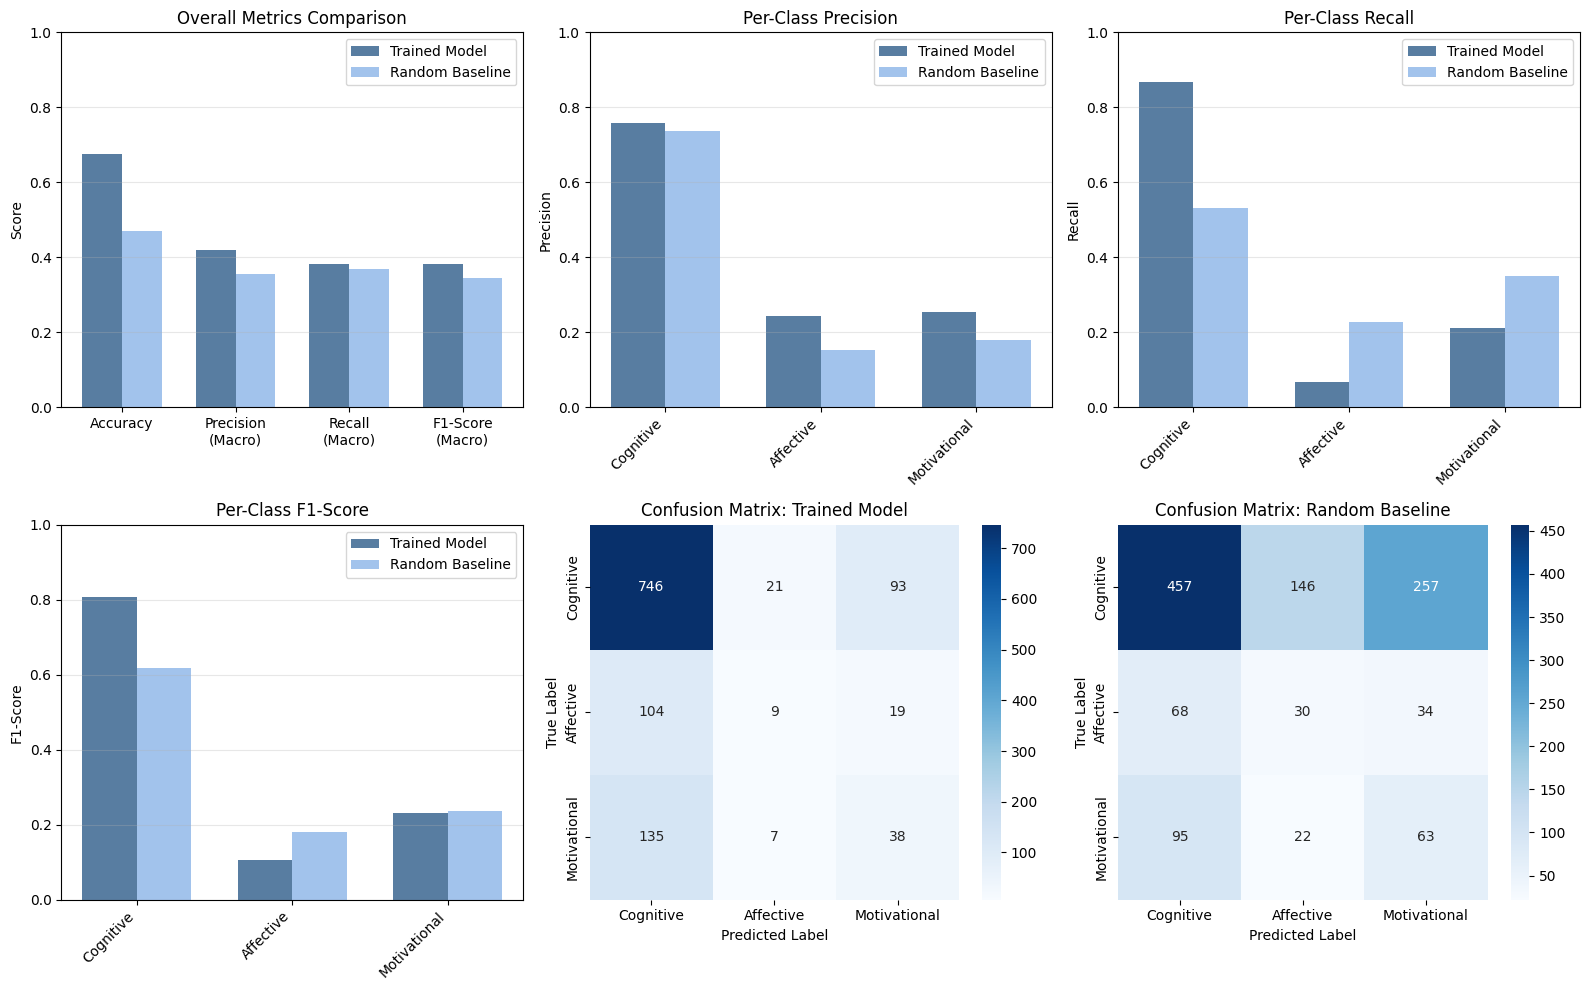


CONFUSION MATRICES

Trained Model:
[[746  21  93]
 [104   9  19]
 [135   7  38]]

Random Baseline:
[[457 146 257]
 [ 68  30  34]
 [ 95  22  63]]


In [13]:
# Comprehensive evaluation: Trained model vs Random baseline
from model import BaselineModel
from data import get_dataloaders
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load trained model
model = BaselineModel().to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

# Get all data loaders
train_loader, eval_loader, test_loader = get_dataloaders(batch_size=32)

# Compute training statistics for random baseline
all_train_labels = []
for batch in train_loader:
    all_train_labels.append(batch['labels'].numpy())
all_train_labels = np.vstack(all_train_labels)
train_mean = all_train_labels.mean(axis=0)
train_std = all_train_labels.std(axis=0)

# Collect all test predictions
all_true_hard = []
all_pred_hard = []
all_random_hard = []
all_true_soft = []
all_pred_soft = []
all_random_soft = []

print("Evaluating on test set...")
for batch in test_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    with torch.no_grad():
        probs = model(input_ids, attention_mask)
        pred_hard = torch.argmax(probs, dim=1).cpu().numpy()
        true_hard = torch.argmax(labels, dim=1).cpu().numpy()
        true_soft = labels.cpu().numpy()
        pred_soft = probs.cpu().numpy()

    # Generate random baseline predictions
    batch_size = len(true_hard)
    random_probs_batch = []
    for _ in range(batch_size):
        random_probs = np.random.normal(train_mean, train_std)
        random_probs = np.clip(random_probs, 0, 1)
        random_probs = random_probs / random_probs.sum()
        random_probs_batch.append(random_probs)
    random_probs_batch = np.array(random_probs_batch)
    random_hard = np.argmax(random_probs_batch, axis=1)

    all_true_hard.extend(true_hard)
    all_pred_hard.extend(pred_hard)
    all_random_hard.extend(random_hard)
    all_true_soft.append(true_soft)
    all_pred_soft.append(pred_soft)
    all_random_soft.append(random_probs_batch)

all_true_hard = np.array(all_true_hard)
all_pred_hard = np.array(all_pred_hard)
all_random_hard = np.array(all_random_hard)

# Compute metrics for both models
class_names = ['Cognitive', 'Affective', 'Motivational']

def compute_metrics(y_true, y_pred, name):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )
    precision_macro = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )[0]
    recall_macro = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )[1]
    f1_macro = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )[2]

    cm = confusion_matrix(y_true, y_pred)

    return {
        'name': name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'support': support,
        'confusion_matrix': cm
    }

metrics_trained = compute_metrics(all_true_hard, all_pred_hard, 'Trained Model')
metrics_random = compute_metrics(all_true_hard, all_random_hard, 'Random Baseline')

# Print detailed metrics
print("\n" + "="*80)
print("COMPREHENSIVE EVALUATION RESULTS")
print("="*80)

print(f"\n{'Metric':<20} {'Trained Model':<20} {'Random Baseline':<20}")
print("-" * 60)
print(f"{'Overall Accuracy':<20} {metrics_trained['accuracy']:<20.4f} {metrics_random['accuracy']:<20.4f}")
print(f"{'Macro Precision':<20} {metrics_trained['precision_macro']:<20.4f} {metrics_random['precision_macro']:<20.4f}")
print(f"{'Macro Recall':<20} {metrics_trained['recall_macro']:<20.4f} {metrics_random['recall_macro']:<20.4f}")
print(f"{'Macro F1-Score':<20} {metrics_trained['f1_macro']:<20.4f} {metrics_random['f1_macro']:<20.4f}")

print("\n" + "-"*80)
print("PER-CLASS METRICS")
print("-"*80)

for i, class_name in enumerate(class_names):
    print(f"\n{class_name}:")
    print(f"  Trained Model:    Precision={metrics_trained['precision'][i]:.4f}, "
          f"Recall={metrics_trained['recall'][i]:.4f}, F1={metrics_trained['f1'][i]:.4f}, "
          f"Support={int(metrics_trained['support'][i])}")
    print(f"  Random Baseline:  Precision={metrics_random['precision'][i]:.4f}, "
          f"Recall={metrics_random['recall'][i]:.4f}, F1={metrics_random['f1'][i]:.4f}, "
          f"Support={int(metrics_random['support'][i])}")

# Create visualizations
fig = plt.figure(figsize=(16, 10))

# 1. Overall metrics comparison
ax1 = plt.subplot(2, 3, 1)
metrics_to_plot = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
x = np.arange(len(metrics_to_plot))
width = 0.35
trained_vals = [metrics_trained[m] for m in metrics_to_plot]
random_vals = [metrics_random[m] for m in metrics_to_plot]
ax1.bar(x - width/2, trained_vals, width, label='Trained Model', alpha=0.8, color='#2E5C8A')
ax1.bar(x + width/2, random_vals, width, label='Random Baseline', alpha=0.8, color='#8BB4E8')
ax1.set_ylabel('Score')
ax1.set_title('Overall Metrics Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(['Accuracy', 'Precision\n(Macro)', 'Recall\n(Macro)', 'F1-Score\n(Macro)'], rotation=0, ha='center')
ax1.legend()
ax1.set_ylim([0, 1])
ax1.grid(True, alpha=0.3, axis='y')

# 2. Per-class precision
ax2 = plt.subplot(2, 3, 2)
x = np.arange(len(class_names))
ax2.bar(x - width/2, metrics_trained['precision'], width, label='Trained Model', alpha=0.8, color='#2E5C8A')
ax2.bar(x + width/2, metrics_random['precision'], width, label='Random Baseline', alpha=0.8, color='#8BB4E8')
ax2.set_ylabel('Precision')
ax2.set_title('Per-Class Precision')
ax2.set_xticks(x)
ax2.set_xticklabels(class_names, rotation=45, ha='right')
ax2.legend()
ax2.set_ylim([0, 1])
ax2.grid(True, alpha=0.3, axis='y')

# 3. Per-class recall
ax3 = plt.subplot(2, 3, 3)
ax3.bar(x - width/2, metrics_trained['recall'], width, label='Trained Model', alpha=0.8, color='#2E5C8A')
ax3.bar(x + width/2, metrics_random['recall'], width, label='Random Baseline', alpha=0.8, color='#8BB4E8')
ax3.set_ylabel('Recall')
ax3.set_title('Per-Class Recall')
ax3.set_xticks(x)
ax3.set_xticklabels(class_names, rotation=45, ha='right')
ax3.legend()
ax3.set_ylim([0, 1])
ax3.grid(True, alpha=0.3, axis='y')

# 4. Per-class F1-score
ax4 = plt.subplot(2, 3, 4)
ax4.bar(x - width/2, metrics_trained['f1'], width, label='Trained Model', alpha=0.8, color='#2E5C8A')
ax4.bar(x + width/2, metrics_random['f1'], width, label='Random Baseline', alpha=0.8, color='#8BB4E8')
ax4.set_ylabel('F1-Score')
ax4.set_title('Per-Class F1-Score')
ax4.set_xticks(x)
ax4.set_xticklabels(class_names, rotation=45, ha='right')
ax4.legend()
ax4.set_ylim([0, 1])
ax4.grid(True, alpha=0.3, axis='y')

# 5. Confusion matrix - Trained Model
ax5 = plt.subplot(2, 3, 5)
sns.heatmap(metrics_trained['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=ax5)
ax5.set_title('Confusion Matrix: Trained Model')
ax5.set_ylabel('True Label')
ax5.set_xlabel('Predicted Label')

# 6. Confusion matrix - Random Baseline
ax6 = plt.subplot(2, 3, 6)
sns.heatmap(metrics_random['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=ax6)
ax6.set_title('Confusion Matrix: Random Baseline')
ax6.set_ylabel('True Label')
ax6.set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Print confusion matrices
print("\n" + "="*80)
print("CONFUSION MATRICES")
print("="*80)
print("\nTrained Model:")
print(metrics_trained['confusion_matrix'])
print("\nRandom Baseline:")
print(metrics_random['confusion_matrix'])

## Option 2: Hyperparameter Search


In [15]:
# Hyperparameter grid search
from itertools import product

# Define hyperparameter grid
learning_rates = [1e-4, 5e-4, 1e-3, 2e-3]
batch_sizes = [16, 32, 64]
patiences = [3, 5, 7]
max_epochs = 50  # Keep same for all

results = []
best_score = float('inf')
best_params = None

print("Starting hyperparameter search...")
print(f"Total combinations: {len(learning_rates) * len(batch_sizes) * len(patiences)}")
print("=" * 60)

for lr, bs, patience in product(learning_rates, batch_sizes, patiences):
    print(f"\nTesting: lr={lr}, batch_size={bs}, patience={patience}")

    # Train with these hyperparameters (don't save model during search)
    eval_loss = train_model(
        max_epochs=max_epochs,
        patience=patience,
        batch_size=bs,
        learning_rate=lr,
        model_save_path=None,  # Don't save during search
        verbose=False  # Less verbose during search
    )

    results.append({
        'lr': lr,
        'batch_size': bs,
        'patience': patience,
        'eval_loss': eval_loss
    })

    if eval_loss < best_score:
        best_score = eval_loss
        best_params = {'lr': lr, 'batch_size': bs, 'patience': patience}
        print(f"  → New best! Eval loss: {eval_loss:.4f}")

print("\n" + "=" * 60)
print("Hyperparameter search completed!")
print(f"\nBest parameters: {best_params}")
print(f"Best evaluation loss: {best_score:.4f}")

# Train final model with best parameters and save it
print("\nTraining final model with best parameters...")
model_path = os.path.join('..', 'models', 'baseline_v1_tuned.pt')
os.makedirs(os.path.dirname(model_path), exist_ok=True)

train_model(
    max_epochs=max_epochs,
    patience=best_params['patience'],
    batch_size=best_params['batch_size'],
    learning_rate=best_params['lr'],
    model_save_path=model_path,
    verbose=True
)

Starting hyperparameter search...
Total combinations: 36

Testing: lr=0.0001, batch_size=16, patience=3
  → New best! Eval loss: 1.0972

Testing: lr=0.0001, batch_size=16, patience=5

Testing: lr=0.0001, batch_size=16, patience=7

Testing: lr=0.0001, batch_size=32, patience=3
  → New best! Eval loss: 1.0960

Testing: lr=0.0001, batch_size=32, patience=5

Testing: lr=0.0001, batch_size=32, patience=7

Testing: lr=0.0001, batch_size=64, patience=3

Testing: lr=0.0001, batch_size=64, patience=5

Testing: lr=0.0001, batch_size=64, patience=7

Testing: lr=0.0005, batch_size=16, patience=3

Testing: lr=0.0005, batch_size=16, patience=5

Testing: lr=0.0005, batch_size=16, patience=7

Testing: lr=0.0005, batch_size=32, patience=3

Testing: lr=0.0005, batch_size=32, patience=5

Testing: lr=0.0005, batch_size=32, patience=7

Testing: lr=0.0005, batch_size=64, patience=3

Testing: lr=0.0005, batch_size=64, patience=5

Testing: lr=0.0005, batch_size=64, patience=7

Testing: lr=0.001, batch_size=16

1.0975606143474579

## Evaluation of Best Hyperparameter Model

After training the final model with the best hyperparameters from the grid search, this cell evaluates its performance on the test set. It computes precision, recall, F1-score, and confusion matrices to assess how well the optimized model generalizes to Study 3 data.

Evaluating best hyperparameter model on test set...

EVALUATION RESULTS: Best Hyperparameter Model

Overall Accuracy: 0.6766
Macro Precision: 0.4180
Macro Recall: 0.3822
Macro F1-Score: 0.3818

--------------------------------------------------------------------------------
PER-CLASS METRICS
--------------------------------------------------------------------------------

Cognitive:
  Precision: 0.7574
  Recall:    0.8674
  F1-Score:  0.8087
  Support:   860

Affective:
  Precision: 0.2432
  Recall:    0.0682
  F1-Score:  0.1065
  Support:   132

Motivational:
  Precision: 0.2533
  Recall:    0.2111
  F1-Score:  0.2303
  Support:   180


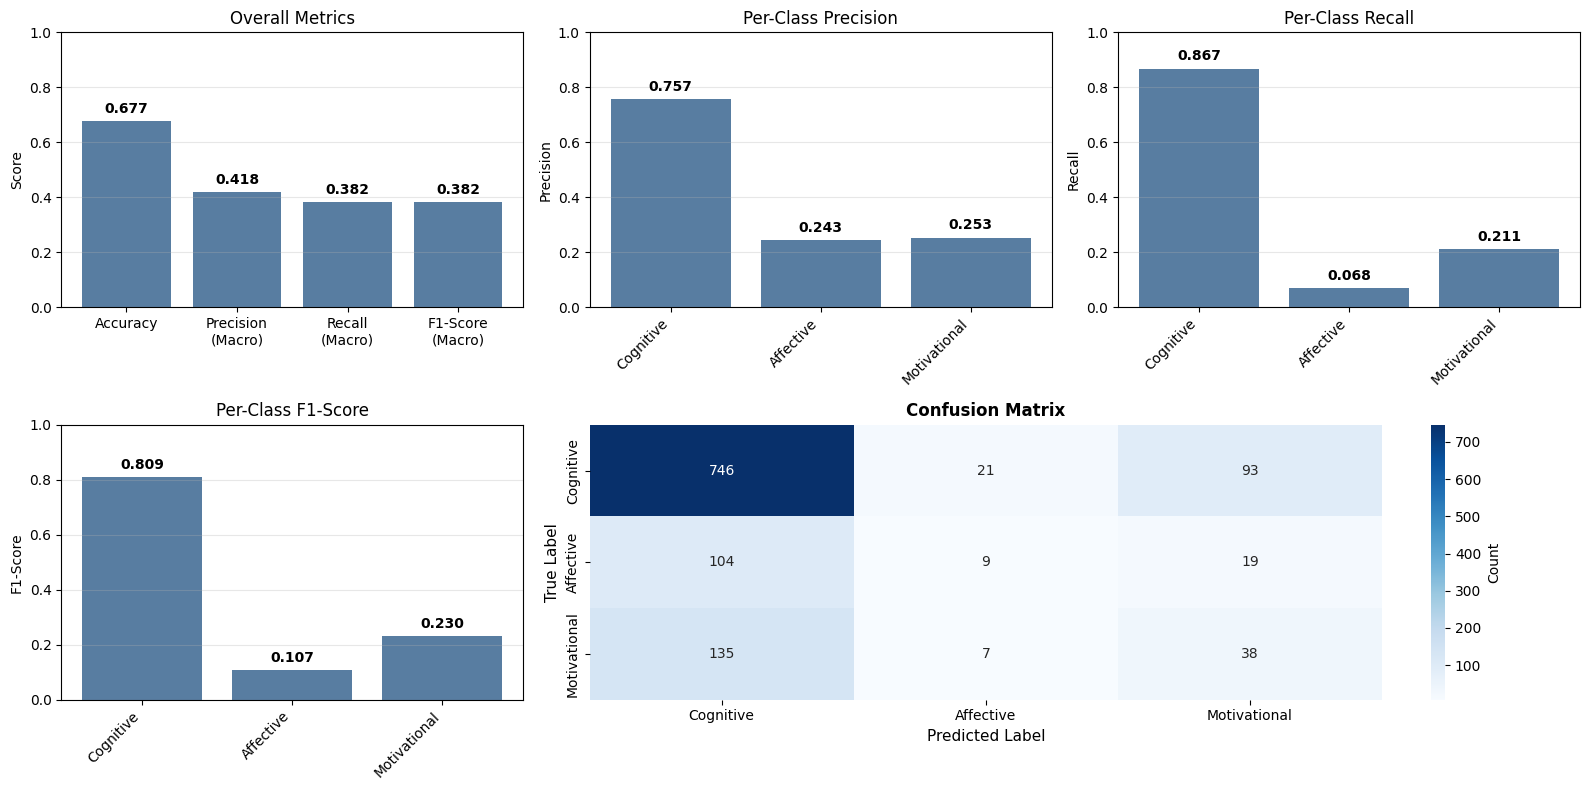


CONFUSION MATRIX

               Cognitive      Affective      Motivational   
Cognitive      746            21             93             
Affective      104            9              19             
Motivational   135            7              38             

SUMMARY
Best hyperparameters: {'lr': 0.0001, 'batch_size': 32, 'patience': 3}
Test Accuracy: 0.6766
Test F1-Score (Macro): 0.3818

The model trained with best hyperparameters achieves 67.66% accuracy
and 0.3818 macro F1-score on the test set (Study 3).


In [16]:
# Evaluate the best hyperparameter model
from model import BaselineModel
from data import get_dataloaders
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the trained model (trained with best hyperparameters)
model = BaselineModel().to(device)
model_path = os.path.join('..', 'models', 'baseline_v1.pt')
if not os.path.exists(model_path):
    model_path = os.path.join('models', 'baseline_v1.pt')
model.load_state_dict(torch.load(model_path))
model.eval()

# Get test loader
_, _, test_loader = get_dataloaders(batch_size=32)

# Collect all test predictions
all_true_hard = []
all_pred_hard = []
all_true_soft = []
all_pred_soft = []

print("Evaluating best hyperparameter model on test set...")
for batch in test_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    with torch.no_grad():
        probs = model(input_ids, attention_mask)
        pred_hard = torch.argmax(probs, dim=1).cpu().numpy()
        true_hard = torch.argmax(labels, dim=1).cpu().numpy()
        true_soft = labels.cpu().numpy()
        pred_soft = probs.cpu().numpy()

    all_true_hard.extend(true_hard)
    all_pred_hard.extend(pred_hard)
    all_true_soft.append(true_soft)
    all_pred_soft.append(pred_soft)

all_true_hard = np.array(all_true_hard)
all_pred_hard = np.array(all_pred_hard)

# Compute metrics
class_names = ['Cognitive', 'Affective', 'Motivational']

accuracy = accuracy_score(all_true_hard, all_pred_hard)
precision, recall, f1, support = precision_recall_fscore_support(
    all_true_hard, all_pred_hard, average=None, zero_division=0
)
precision_macro = precision_recall_fscore_support(
    all_true_hard, all_pred_hard, average='macro', zero_division=0
)[0]
recall_macro = precision_recall_fscore_support(
    all_true_hard, all_pred_hard, average='macro', zero_division=0
)[1]
f1_macro = precision_recall_fscore_support(
    all_true_hard, all_pred_hard, average='macro', zero_division=0
)[2]

cm = confusion_matrix(all_true_hard, all_pred_hard)

# Print detailed metrics
print("\n" + "="*80)
print("EVALUATION RESULTS: Best Hyperparameter Model")
print("="*80)
print(f"\nOverall Accuracy: {accuracy:.4f}")
print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall: {recall_macro:.4f}")
print(f"Macro F1-Score: {f1_macro:.4f}")

print("\n" + "-"*80)
print("PER-CLASS METRICS")
print("-"*80)
for i, class_name in enumerate(class_names):
    print(f"\n{class_name}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall:    {recall[i]:.4f}")
    print(f"  F1-Score:  {f1[i]:.4f}")
    print(f"  Support:   {int(support[i])}")

# Create visualizations
fig = plt.figure(figsize=(16, 8))

# 1. Overall metrics
ax1 = plt.subplot(2, 3, 1)
metrics_to_plot = ['Accuracy', 'Precision\n(Macro)', 'Recall\n(Macro)', 'F1-Score\n(Macro)']
values = [accuracy, precision_macro, recall_macro, f1_macro]
x = np.arange(len(metrics_to_plot))
ax1.bar(x, values, alpha=0.8, color='#2E5C8A')
ax1.set_ylabel('Score')
ax1.set_title('Overall Metrics')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics_to_plot, rotation=0, ha='center')
ax1.set_ylim([0, 1])
ax1.grid(True, alpha=0.3, axis='y')
# Add value labels on bars
for i, v in enumerate(values):
    ax1.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. Per-class precision
ax2 = plt.subplot(2, 3, 2)
x = np.arange(len(class_names))
ax2.bar(x, precision, alpha=0.8, color='#2E5C8A')
ax2.set_ylabel('Precision')
ax2.set_title('Per-Class Precision')
ax2.set_xticks(x)
ax2.set_xticklabels(class_names, rotation=45, ha='right')
ax2.set_ylim([0, 1])
ax2.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(precision):
    ax2.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# 3. Per-class recall
ax3 = plt.subplot(2, 3, 3)
ax3.bar(x, recall, alpha=0.8, color='#2E5C8A')
ax3.set_ylabel('Recall')
ax3.set_title('Per-Class Recall')
ax3.set_xticks(x)
ax3.set_xticklabels(class_names, rotation=45, ha='right')
ax3.set_ylim([0, 1])
ax3.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(recall):
    ax3.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# 4. Per-class F1-score
ax4 = plt.subplot(2, 3, 4)
ax4.bar(x, f1, alpha=0.8, color='#2E5C8A')
ax4.set_ylabel('F1-Score')
ax4.set_title('Per-Class F1-Score')
ax4.set_xticks(x)
ax4.set_xticklabels(class_names, rotation=45, ha='right')
ax4.set_ylim([0, 1])
ax4.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(f1):
    ax4.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# 5. Confusion matrix
ax5 = plt.subplot(2, 3, (5, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=ax5,
            cbar_kws={'label': 'Count'})
ax5.set_title('Confusion Matrix', fontsize=12, fontweight='bold')
ax5.set_ylabel('True Label', fontsize=11)
ax5.set_xlabel('Predicted Label', fontsize=11)

plt.tight_layout()
plt.show()

# Print confusion matrix
print("\n" + "="*80)
print("CONFUSION MATRIX")
print("="*80)
print(f"\n{'':<15}", end='')
for name in class_names:
    print(f"{name:<15}", end='')
print()
for i, name in enumerate(class_names):
    print(f"{name:<15}", end='')
    for j in range(len(class_names)):
        print(f"{cm[i, j]:<15}", end='')
    print()

# Summary
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print(f"Best hyperparameters: {best_params}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1-Score (Macro): {f1_macro:.4f}")
print(f"\nThe model trained with best hyperparameters achieves {accuracy*100:.2f}% accuracy")
print(f"and {f1_macro:.4f} macro F1-score on the test set (Study 3).")